# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1VLVgb3fD02XrF2V5OruKvQTOT91juXcs&export=download'
        output = 'songs_dataset.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1VLVgb3fD02XrF2V5OruKvQTOT91juXcs&export=download
To: /content/songs_dataset.zip
100%|██████████| 2.09M/2.09M [00:00<00:00, 92.4MB/s]


In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['beatles.txt',
 'Kanye_West.txt',
 'britney-spears.txt',
 'alicia-keys.txt',
 'dr-seuss.txt',
 'rihanna.txt',
 'leonard-cohen.txt',
 'nursery_rhymes.txt',
 'paul-simon.txt',
 'lil-wayne.txt',
 'nirvana.txt',
 'r-kelly.txt',
 'notorious_big.txt',
 'al-green.txt',
 'bob-dylan.txt',
 'patti-smith.txt',
 'amy-winehouse.txt',
 'dickinson.txt',
 'jimi-hendrix.txt',
 'bruce-springsteen.txt',
 'notorious-big.txt',
 'lin-manuel-miranda.txt',
 'nickelback.txt',
 'kanye.txt',
 'bob-marley.txt',
 'dolly-parton.txt',
 'missy-elliott.txt',
 'janisjoplin.txt',
 'adele.txt',
 'nicki-minaj.txt',
 'blink-182.txt',
 'johnny-cash.txt',
 'eminem.txt',
 'radiohead.txt',
 'lady-gaga.txt',
 'ludacris.txt',
 'bjork.txt',
 'bieber.txt',
 'drake.txt',
 'prince.txt',
 'cake.txt',
 'lorde.txt',
 'dj-khaled.txt',
 'joni-mitchell.txt',
 'kanye-west.txt',
 'Lil_Wayne.txt',
 'disney.txt',
 'michael-jackson.txt',
 'bruno-mars.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/bruno-mars.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0
0,Now greetings to the world! Standing at this l...
1,"Whiskey coming through my pores,"
2,Feeling like I run this whole block.
3,Lotto tickets cheap beer
4,"That's why you can catch me here,"


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3270


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [7]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Now greetings to the world! Standing at this liquor store,'

In [8]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['now',
 'greetings',
 'to',
 'the',
 'world',
 'standing',
 'at',
 'this',
 'liquor',
 'store']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [9]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [10]:
# Demos un vistazo
sentence_tokens[:2]

[['now',
  'greetings',
  'to',
  'the',
  'world',
  'standing',
  'at',
  'this',
  'liquor',
  'store'],
 ['whiskey', 'coming', 'through', 'my', 'pores']]

In [11]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['now', 'greetings', 'to', 'the'],
 ['greetings', 'to', 'the', 'world'],
 ['to', 'the', 'world', 'standing'],
 ['the', 'world', 'standing', 'at'],
 ['world', 'standing', 'at', 'this'],
 ['standing', 'at', 'this', 'liquor']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [13]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [14]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[8, 6, 4, 1],
 [6, 4, 1, 2],
 [4, 1, 2, 3],
 [1, 2, 3, 5],
 [2, 3, 5, 7],
 [3, 5, 7, 9]]

In [15]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

6


In [16]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

9


In [17]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'world': 2, 'standing': 3, 'to': 4, 'at': 5, 'greetings': 6, 'this': 7, 'now': 8, 'liquor': 9}


In [18]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'the': 4, 'to': 3, 'now': 1, 'greetings': 2, 'world': 4, 'standing': 4, 'at': 3, 'this': 2, 'liquor': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [19]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Now greetings to the world! Standing at this l...
1                      Whiskey coming through my pores,
2                  Feeling like I run this whole block.
3                              Lotto tickets cheap beer
4                     That's why you can catch me here,
5     Tryna scratch my way up to the top. 'Cause my ...
6                       So I ain't got a thing to lose.
7                Take me to a place where I don't care,
8     This is me and my liquor store blues. I'll tak...
9                               One drag for my sorrow.
10                                 Get messed up today,
11                                 I'll be ok tomorrow.
12                                One shot for my pain,
13                              One drag for my sorrow.
14                                 Get messed up today,
15       I'll be ok tomorrow. Me and my guitar tonight,
Name: 0, dtype: object

In [20]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Now greetings to the world! Standing at this liquor store, Whiskey coming through my pores, Feeling like I run this whole block. Lotto tickets cheap beer That\'s why you can catch me here, Tryna scratch my way up to the top. \'Cause my job got me going nowhere, So I ain\'t got a thing to lose. Take me to a place where I don\'t care, This is me and my liquor store blues. I\'ll take one shot for my pain, One drag for my sorrow. Get messed up today, I\'ll be ok tomorrow. One shot for my pain, One drag for my sorrow. Get messed up today, I\'ll be ok tomorrow. Me and my guitar tonight, Singing to the city lights, Tryna live on more than what I got. \'Cause \'68 cents ain\'t gonna pay the rent, So I\'ll be out here \'til they call the cops. \'Cause my job got me going nowhere, So I ain\'t got a thing to lose. Take me to a place where I don\'t care, This is me and my liquor store blues. I\'ll take one shot for my pain, One drag for my sorrow. Get messed up today, I\'ll be ok tomorrow. One sh

In [21]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['now',
 'greetings',
 'to',
 'the',
 'world',
 'standing',
 'at',
 'this',
 'liquor',
 'store',
 'whiskey',
 'coming',
 'through',
 'my',
 'pores',
 'feeling',
 'like',
 'i',
 'run',
 'this']

In [22]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 26900


In [23]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [24]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['now', 'greetings', 'to', 'the'],
 ['greetings', 'to', 'the', 'world'],
 ['to', 'the', 'world', 'standing'],
 ['the', 'world', 'standing', 'at'],
 ['world', 'standing', 'at', 'this'],
 ['standing', 'at', 'this', 'liquor'],
 ['at', 'this', 'liquor', 'store'],
 ['this', 'liquor', 'store', 'whiskey'],
 ['liquor', 'store', 'whiskey', 'coming'],
 ['store', 'whiskey', 'coming', 'through'],
 ['whiskey', 'coming', 'through', 'my'],
 ['coming', 'through', 'my', 'pores'],
 ['through', 'my', 'pores', 'feeling'],
 ['my', 'pores', 'feeling', 'like'],
 ['pores', 'feeling', 'like', 'i'],
 ['feeling', 'like', 'i', 'run'],
 ['like', 'i', 'run', 'this'],
 ['i', 'run', 'this', 'whole'],
 ['run', 'this', 'whole', 'block'],
 ['this', 'whole', 'block', 'lotto']]

In [25]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[47, 614, 6, 3],
 [614, 6, 3, 133],
 [6, 3, 133, 360],
 [3, 133, 360, 76],
 [133, 360, 76, 38],
 [360, 76, 38, 336],
 [76, 38, 336, 410],
 [38, 336, 410, 813],
 [336, 410, 813, 237],
 [410, 813, 237, 154],
 [813, 237, 154, 7],
 [237, 154, 7, 814],
 [154, 7, 814, 286],
 [7, 814, 286, 20],
 [814, 286, 20, 2],
 [286, 20, 2, 87],
 [20, 2, 87, 38],
 [2, 87, 38, 155],
 [87, 38, 155, 384],
 [38, 155, 384, 815]]

In [26]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 26896


### 3 - Input y target

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [29]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [30]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(26896, 3)
(26896,)


In [31]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'me',
 5: 'it',
 6: 'to',
 7: 'my',
 8: 'oh',
 9: 'and',
 10: 'a',
 11: 'for',
 12: 'yeah',
 13: 'in',
 14: 'on',
 15: 'so',
 16: 'up',
 17: 'what',
 18: 'all',
 19: "i'm",
 20: 'like',
 21: 'your',
 22: 'that',
 23: 'got',
 24: "don't",
 25: 'no',
 26: 'know',
 27: 'just',
 28: 'we',
 29: 'her',
 30: 'is',
 31: 'do',
 32: 'baby',
 33: 'be',
 34: 'girl',
 35: 'but',
 36: 'she',
 37: "it's",
 38: 'this',
 39: 'when',
 40: "you're",
 41: 'if',
 42: 'of',
 43: "'cause",
 44: 'go',
 45: 'take',
 46: 'can',
 47: 'now',
 48: 'with',
 49: 'out',
 50: 'love',
 51: 'are',
 52: "that's",
 53: 'way',
 54: 'get',
 55: 'see',
 56: 'make',
 57: 'say',
 58: "i'll",
 59: 'time',
 60: 'here',
 61: 'too',
 62: 'one',
 63: 'tell',
 64: 'long',
 65: "can't",
 66: 'feel',
 67: 'night',
 68: 'come',
 69: 'ooh',
 70: 'wanna',
 71: 'never',
 72: 'been',
 73: 'que',
 74: 'show',
 75: 'down',
 76: 'at',
 77: 'where',
 78: 'better',
 79: 'gimme',
 80: 'more',
 81: 'want',
 82: 

In [32]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1896

In [33]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(26896, 1896)

### 4 - Entrenar el modelo

In [34]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [35]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1896

In [42]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(128, activation='relu'))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3, 5)              9485      
_________________________________________________________________
lstm_26 (LSTM)               (None, 3, 64)             17920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_28 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_29 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
dense_19 (Dense)             (None, 3, 128)           

In [43]:
hist = model.fit(x_data, y_data, epochs=250, validation_split=0.2)

Epoch 1/250
673/673 [==============================] - 36s 35ms/step - loss: 6.1175 - accuracy: 0.0399 - val_loss: 6.3164 - val_accuracy: 0.0444
Epoch 2/250
673/673 [==============================] - 20s 30ms/step - loss: 5.8709 - accuracy: 0.0422 - val_loss: 6.3312 - val_accuracy: 0.0489
Epoch 3/250
673/673 [==============================] - 20s 30ms/step - loss: 5.7592 - accuracy: 0.0434 - val_loss: 6.2730 - val_accuracy: 0.0528
Epoch 4/250
673/673 [==============================] - 20s 30ms/step - loss: 5.6634 - accuracy: 0.0450 - val_loss: 6.2092 - val_accuracy: 0.0563
Epoch 5/250
673/673 [==============================] - 20s 30ms/step - loss: 5.5782 - accuracy: 0.0476 - val_loss: 6.2261 - val_accuracy: 0.0480
Epoch 6/250
673/673 [==============================] - 20s 30ms/step - loss: 5.4928 - accuracy: 0.0508 - val_loss: 6.2784 - val_accuracy: 0.0526
Epoch 7/250
673/673 [==============================] - 20s 30ms/step - loss: 5.4056 - accuracy: 0.0525 - val_loss: 6.2489 - val_ac

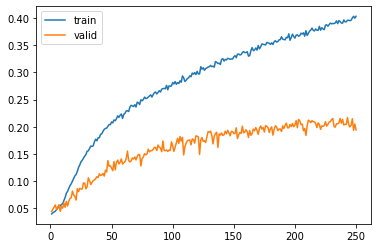

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [45]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [46]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 3.6 MB 5.2 MB/s 
     |████████████████████████████████| 1.9 MB 35.9 MB/s 
     |████████████████████████████████| 206 kB 46.1 MB/s 
     |████████████████████████████████| 3.5 MB 39.1 MB/s 
     |████████████████████████████████| 961 kB 42.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [47]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://30932.gradio.app


KeyboardInterrupt: ignored

Frase original : I'll probably take **whatever's left and just** split it up

### 6 - Generación de secuencias nuevas

In [48]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [55]:
input_text="A different city every"

generate_seq(model, tok, input_text, max_length=3, n_words=2)

'A different city every feel on'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.